# Clustering de películas (TMDB)
Preparación de datos para clustering con preprocesamiento completo: selección de variables, nulos, outliers, escalado y correlación.

In [1]:
# 1) Cargar datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data/movies_2026.csv',encoding='latin-1')
print(df.shape)
df.head(3)

(19883, 28)


,id,budget,genres,homePage,productionCompany,productionCompanyCountry,productionCountry,revenue,runtime,video,...,releaseDate,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount,releaseYear
0,1627085,0.0,Drama|Crime,NaN,NaN,NaN,NaN,0.0,95,False,...,2026-02-01,0.0,0,2,0,0,8,2.0,5.0,2026.0
1,1626914,0.0,Animation,NaN,NaN,NaN,NaN,0.0,3,False,...,2026-02-01,0.0,0,1,0,0,4,0.0,0.0,2026.0
2,1626898,0.0,Animation,NaN,NaN,NaN,NaN,0.0,2,False,...,2026-02-01,0.0,0,1,0,0,3,0.0,0.0,2026.0


## Selección de variables para clustering
**Se usan** variables numéricas de desempeño (`popularity`, `budget`, `revenue`, `runtime`, `voteAvg`, `voteCount`, `releaseYear`) y composición (`castWomenAmount`, `castMenAmount`).

**Campos tipo array (`|`)**: en lugar de usarlos como texto, se transforman a features numéricas (conteos por película y promedio de `actorsPopularity`).

**Se descartan** textos crudos (`title`, `originalTitle`, `director`, `actorsCharacter`, etc.) porque no son directamente comparables por distancia en clustering.

In [2]:
# 3) Construir matriz base de features (incluyendo arrays con '|') y revisar nulos
def split_count(series):
    return series.fillna('').astype(str).str.split('|').apply(
        lambda parts: sum(1 for p in parts if str(p).strip() != '')
    )

def split_mean_numeric(series):
    def _mean_from_pipe(value):
        if pd.isna(value) or str(value).strip() == '':
            return np.nan
        vals = []
        for token in str(value).split('|'):
            token = token.strip()
            if token != '':
                try:
                    vals.append(float(token))
                except ValueError:
                    pass
        return float(np.mean(vals)) if vals else np.nan
    return series.apply(_mean_from_pipe)

# Conteos derivados desde campos tipo array
df['genresCount'] = pd.to_numeric(df['genresAmount'], errors='coerce').fillna(split_count(df['genres']))
df['productionCompanyCount'] = pd.to_numeric(df['productionCoAmount'], errors='coerce').fillna(split_count(df['productionCompany']))
df['productionCountryCount'] = pd.to_numeric(df['productionCountriesAmount'], errors='coerce').fillna(split_count(df['productionCountry']))
df['actorsCount'] = pd.to_numeric(df['actorsAmount'], errors='coerce').fillna(split_count(df['actors']))

# Resumen numérico del array actorsPopularity
df['actorsPopularityMean'] = split_mean_numeric(df['actorsPopularity'])

features = [
    'popularity', 'budget', 'revenue', 'runtime', 'voteAvg', 'voteCount',
    'genresCount', 'productionCompanyCount', 'productionCountryCount',
    'actorsCount', 'actorsPopularityMean', 'castWomenAmount', 'castMenAmount', 'releaseYear'
 ]
X = df[features].copy()

missing = X.isna().sum().sort_values(ascending=False)
print('Nulos por variable:')
display(missing[missing > 0])

Nulos por variable:


actorsPopularityMean    2644
castMenAmount            162
castWomenAmount           37
releaseYear                2
dtype: int64

In [3]:
# 4) Manejo de nulos (imputación robusta con mediana)
X = X.apply(pd.to_numeric, errors='coerce')
X_imputed = X.fillna(X.median(numeric_only=True))
print('Nulos restantes:', int(X_imputed.isna().sum().sum()))

Nulos restantes: 0


In [4]:
# 5) Manejo de outliers (winsorización por IQR: clipping)
Q1 = X_imputed.quantile(0.25)
Q3 = X_imputed.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
X_clean = X_imputed.clip(lower=lower, upper=upper, axis=1)

print('Shape tras control de outliers:', X_clean.shape)

Shape tras control de outliers: (19883, 14)


In [5]:
# 6) Escalado (removiendo variables sin variación)
nunique = X_clean.nunique(dropna=False)
constant_cols = nunique[nunique <= 1].index.tolist()
X_model = X_clean.drop(columns=constant_cols) if constant_cols else X_clean.copy()

if constant_cols:
    print('Columnas removidas por varianza cero:', constant_cols)
else:
    print('No hay columnas con varianza cero')

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_model), columns=X_model.columns, index=X_model.index)
X_scaled.describe().T[['mean', 'std']].head()

Columnas removidas por varianza cero: ['productionCountryCount']


,mean,std
popularity,-1.829693e-16,1.000025
budget,4.574233e-17,1.000025
revenue,0.000000e+00,1.000025
runtime,9.148466e-17,1.000025
voteAvg,-1.829693e-16,1.000025


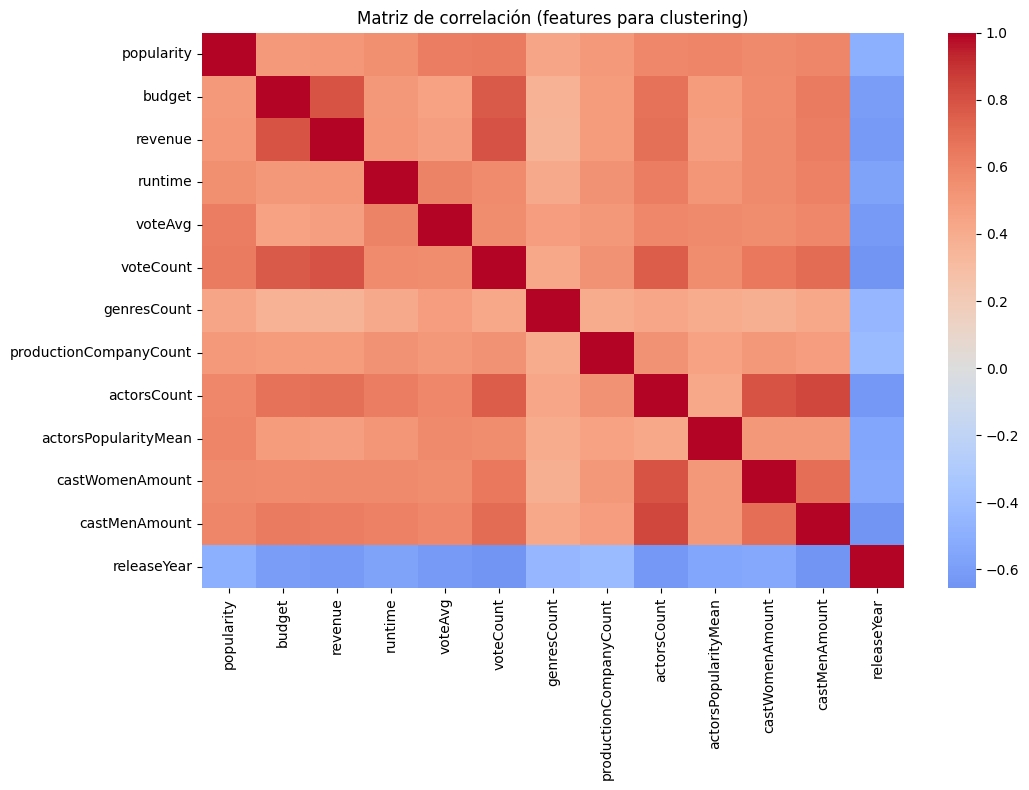

In [6]:
# 7) Matriz de correlación
corr = X_scaled.corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Matriz de correlación (features para clustering)')
plt.tight_layout()
plt.show()

##  Tendencia al clustering: estadístico de Hopkins
Resultado obtenido: **H = 0.8096**.

Interpretación:
- `H` cercano a 0.5: datos casi aleatorios.
- `H` > 0.70: tendencia clara a clustering.
- Con `H = 0.8096`, el dataset presenta **buena tendencia a formar clusters**.

In [7]:
# 9) Cálculo de Hopkins
from sklearn.neighbors import NearestNeighbors

rng = np.random.default_rng(42)
X_h = X_scaled.to_numpy()
n = X_h.shape[0]
d = X_h.shape[1]

m = min(1000, max(100, int(0.05 * n)))  # tamaño de muestra
idx = rng.choice(n, size=m, replace=False)
X_sample = X_h[idx]

mins = X_h.min(axis=0)
maxs = X_h.max(axis=0)
U = rng.uniform(mins, maxs, size=(m, d))

nn_data = NearestNeighbors(n_neighbors=2).fit(X_h)
w_dist, _ = nn_data.kneighbors(X_sample, n_neighbors=2)
W = w_dist[:, 1].sum()

u_dist, _ = nn_data.kneighbors(U, n_neighbors=1)
U_sum = u_dist[:, 0].sum()

hopkins = float(U_sum / (U_sum + W))
print(f'Hopkins H = {hopkins:.4f} (m={m})')

Hopkins H = 0.8096 (m=994)


## VAT (Visual Assessment of Tendency)
Sí fue posible ejecutar VAT sobre una muestra de **n=1200**.

Comentario: se usó muestra porque VAT requiere una matriz de distancias de tamaño \(n^2\); en el dataset completo sería más costoso en memoria/tiempo.

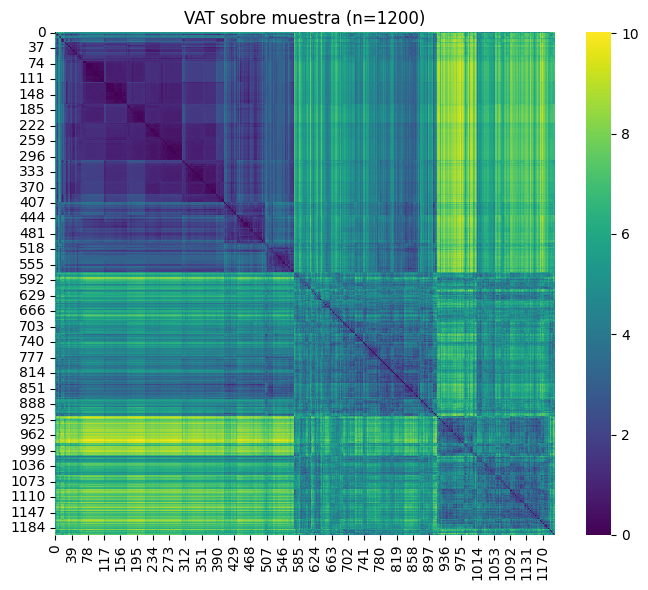

VAT fue posible con muestra n=1200.


In [8]:
# 11) VAT sobre muestra
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

vat_possible = True
vat_reason = ''
n_vat = min(1200, len(X_scaled))

try:
    X_vat = X_scaled.sample(n=n_vat, random_state=42).to_numpy()
    d_condensed = pdist(X_vat, metric='euclidean')
    Z = linkage(d_condensed, method='average')
    order = leaves_list(Z)
    D = squareform(d_condensed)
    D_ordered = D[np.ix_(order, order)]

    plt.figure(figsize=(7, 6))
    sns.heatmap(D_ordered, cmap='viridis', cbar=True)
    plt.title(f'VAT sobre muestra (n={n_vat})')
    plt.tight_layout()
    plt.show()

    print(f'VAT fue posible con muestra n={n_vat}.')
except Exception as e:
    vat_possible = False
    vat_reason = str(e)
    print('VAT no fue posible en esta ejecución.')
    print('Motivo:', vat_reason)

## k elegido 
Se elige **k = 2**.

Justificación breve:
- La **silueta máxima** se obtiene en `k=2` (0.4332).
- La curva de **codo** muestra caída fuerte inicial y luego ganancias decrecientes.
- Por ambos criterios, `k=2` es la opción más consistente para este preprocesamiento.

k óptimo por silueta: 2 (score=0.4332, n_eval=6000)


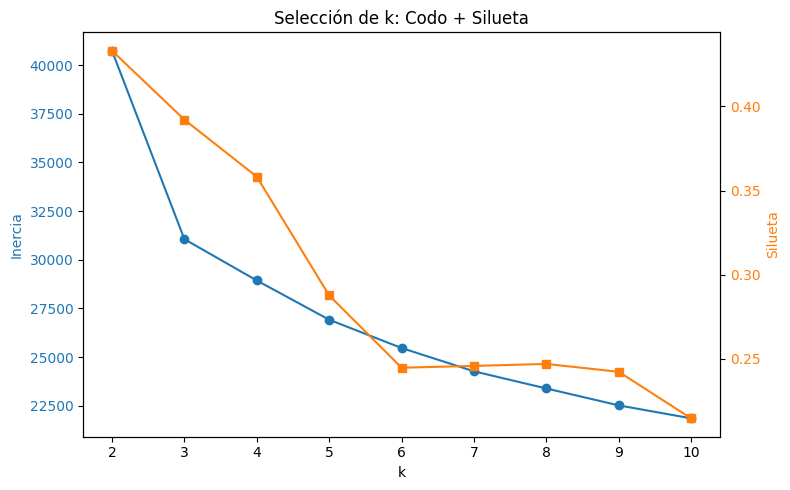

In [9]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = list(range(2, 11))
inertias = []
sil_scores = []

n_eval = min(6000, len(X_scaled))
X_eval = X_scaled.sample(n=n_eval, random_state=42) if len(X_scaled) > n_eval else X_scaled

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_eval)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_eval, labels))

k_opt = k_values[int(np.argmax(sil_scores))]
print(f'k óptimo por silueta: {k_opt} (score={max(sil_scores):.4f}, n_eval={len(X_eval)})')

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(k_values, inertias, marker='o', color='tab:blue')
ax1.set_xlabel('k')
ax1.set_ylabel('Inercia', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(k_values, sil_scores, marker='s', color='tab:orange')
ax2.set_ylabel('Silueta', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Selección de k: Codo + Silueta')
fig.tight_layout()
plt.show()

##  Aplicar KMeans y Clustering Jerárquico (k=2)
Se aplican ambos métodos con el `k` elegido y se comparan visualmente y con métricas internas.

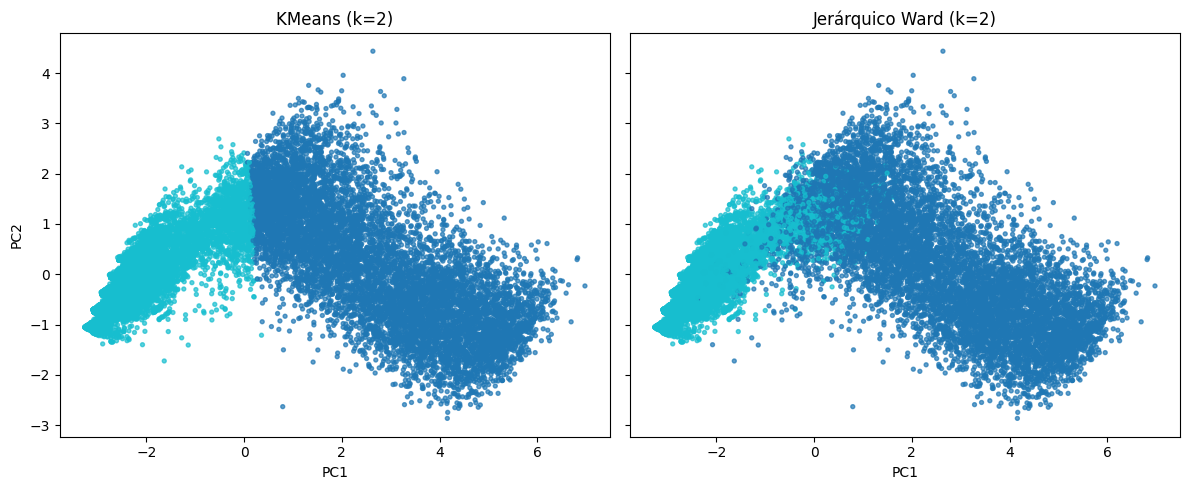

In [10]:
#  Entrenar ambos modelos y visualizar en 2D (PCA)
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

k_final = int(k_opt) if 'k_opt' in globals() else 2

kmeans_model = KMeans(n_clusters=k_final, random_state=42, n_init=20)
labels_kmeans = kmeans_model.fit_predict(X_scaled)

hier_model = AgglomerativeClustering(n_clusters=k_final, linkage='ward')
labels_hier = hier_model.fit_predict(X_scaled)

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmeans, s=8, cmap='tab10', alpha=0.7)
axes[0].set_title(f'KMeans (k={k_final})')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_hier, s=8, cmap='tab10', alpha=0.7)
axes[1].set_title(f'Jerárquico Ward (k={k_final})')
axes[1].set_xlabel('PC1')

plt.tight_layout()
plt.show()

In [11]:
#  Comparación cuantitativa: Silueta + Davies-Bouldin
from sklearn.metrics import silhouette_score, davies_bouldin_score

metrics_df = pd.DataFrame({
    'modelo': ['KMeans', 'Jerárquico (Ward)'],
    'silhouette': [
        silhouette_score(X_scaled, labels_kmeans),
        silhouette_score(X_scaled, labels_hier)
    ],
    'davies_bouldin': [
        davies_bouldin_score(X_scaled, labels_kmeans),
        davies_bouldin_score(X_scaled, labels_hier)
    ]
})

display(metrics_df)

best_by_sil = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'modelo']
best_by_db = metrics_df.loc[metrics_df['davies_bouldin'].idxmin(), 'modelo']
recommended_model = best_by_sil if best_by_sil == best_by_db else best_by_sil

print(f'Mejor por silueta: {best_by_sil}')
print(f'Mejor por Davies-Bouldin (menor es mejor): {best_by_db}')
print(f'Modelo recomendado: {recommended_model}')

,modelo,silhouette,davies_bouldin
0,KMeans,0.431237,0.991866
1,Jerárquico (Ward),0.416271,1.018643


Mejor por silueta: KMeans
Mejor por Davies-Bouldin (menor es mejor): KMeans
Modelo recomendado: KMeans


##  Conclusión del método a usar
Uso de **KMeans** con `k=2`.

Razón:
- Tiene mayor **silueta** (`0.4312` vs `0.4163`), indicando mejor separación/cohesión.
- Tiene menor **Davies-Bouldin** (`0.9919` vs `1.0186`), indicando clusters más compactos y mejor separados.
- También es más simple y eficiente para este tamaño de dataset.

##  Interpretación de clusters (KMeans)
Se perfilan los grupos con estadísticas descriptivas y un heatmap de medias estandarizadas por cluster.

Tamaño por cluster:


,n_peliculas,pct
cluster,,
0,8919,44.86
1,10964,55.14


Estadísticas por cluster (media y mediana):


popularity                budget                  revenue             \
              mean  median          mean     median          mean     median   
cluster                                                                        
0           53.327  22.563  2.096191e+07  3500000.0  6.415827e+07  3346265.0   
1            4.221   0.066  1.869656e+04        0.0  2.246948e+04        0.0   

         runtime        voteAvg         ... actorsCount         \
            mean median    mean median  ...        mean median   
cluster                                 ...                      
0        103.572  101.0   6.539    6.6  ...    1408.219   23.0   
1         35.606   13.0   1.639    0.0  ...     816.717    3.0   

        actorsPopularityMean        castWomenAmount        castMenAmount  \
                        mean median            mean median          mean   
cluster                                                                    
0                      5.498  5.075        5265.824    6.0     12107.243   
1                      0.656  0.055        2095.035    0.0      5091.071   

               releaseYear          
        median        mean  median  
cluster                             
0         13.0    2007.565  2012.0  
1          0.0    2024.363  2025.0  

[2 rows x 26 columns]

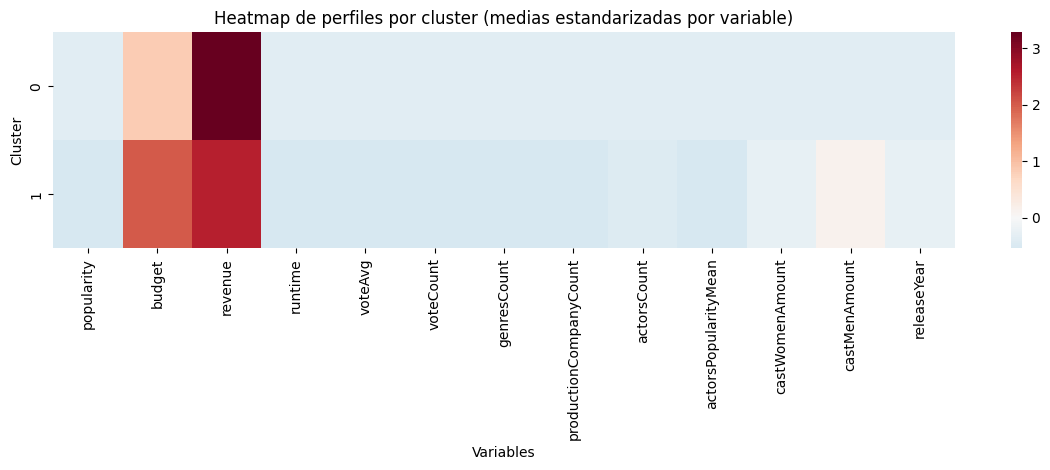

In [12]:

from sklearn.preprocessing import StandardScaler

# Asegurar etiquetas del mejor modelo (KMeans)
if 'labels_kmeans' not in globals():
    kmeans_model = KMeans(n_clusters=2, random_state=42, n_init=20)
    labels_kmeans = kmeans_model.fit_predict(X_scaled)

df_cluster = df.copy()
df_cluster['cluster'] = labels_kmeans

profile_cols = [
    'popularity', 'budget', 'revenue', 'runtime', 'voteAvg', 'voteCount',
    'genresCount', 'productionCompanyCount', 'actorsCount',
    'actorsPopularityMean', 'castWomenAmount', 'castMenAmount', 'releaseYear'
 ]

cluster_size = df_cluster['cluster'].value_counts().sort_index()
cluster_pct = (cluster_size / len(df_cluster) * 100).round(2)
print('Tamaño por cluster:')
display(pd.DataFrame({'n_peliculas': cluster_size, 'pct': cluster_pct}))

profile_stats = df_cluster.groupby('cluster')[profile_cols].agg(['mean', 'median'])
print('Estadísticas por cluster (media y mediana):')
display(profile_stats.round(3))

cluster_means = df_cluster.groupby('cluster')[profile_cols].mean()
scaler_profile = StandardScaler()
cluster_means_z = pd.DataFrame(
    scaler_profile.fit_transform(cluster_means.T).T,
    index=cluster_means.index,
    columns=cluster_means.columns
)

plt.figure(figsize=(12, 4.8))
sns.heatmap(cluster_means_z, cmap='RdBu_r', center=0, annot=False)
plt.title('Heatmap de perfiles por cluster (medias estandarizadas por variable)')
plt.xlabel('Variables')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

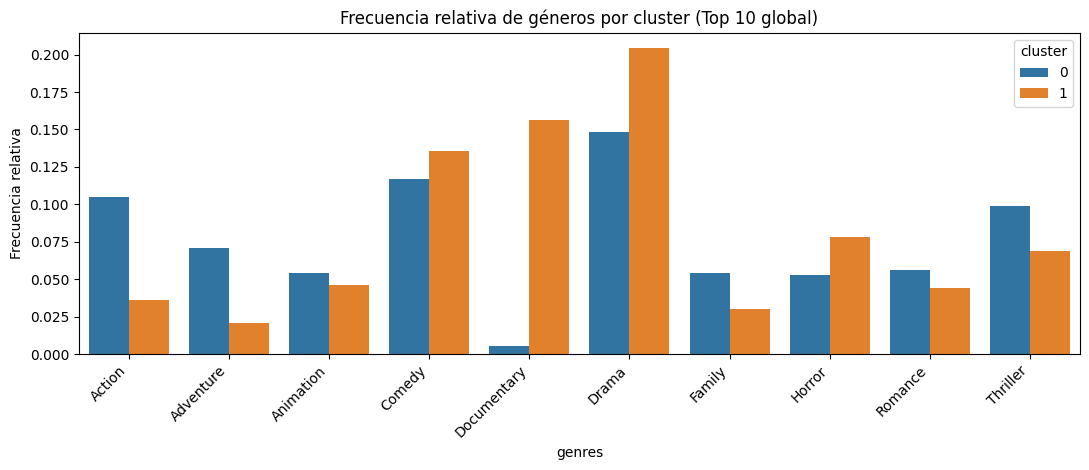

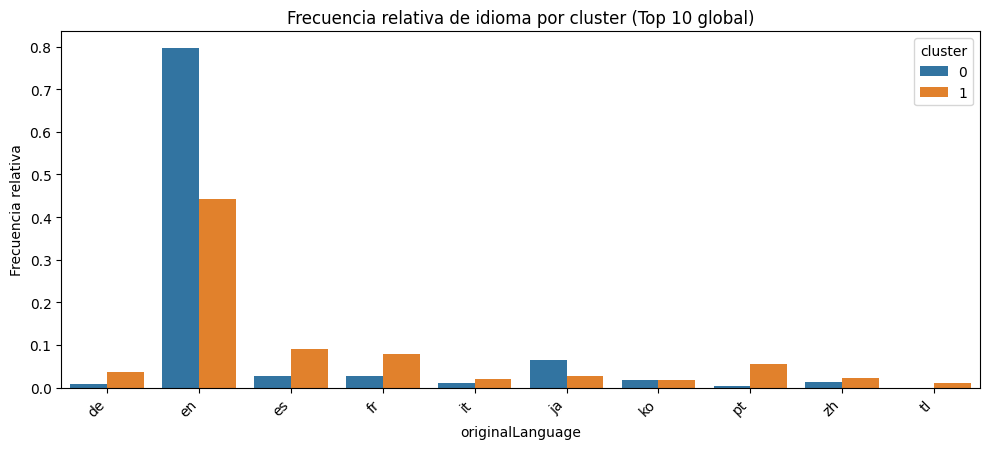

Top 5 géneros por cluster:


,cluster,genres,freq
6,0,Drama,0.148589
3,0,Comedy,0.116984
0,0,Action,0.104960
16,0,Thriller,0.099115
1,0,Adventure,0.071142
25,1,Drama,0.204343
24,1,Documentary,0.156286
22,1,Comedy,0.135729
29,1,Horror,0.077939
35,1,Thriller,0.068750


Top 5 idiomas por cluster:


,cluster,originalLanguage,freq
7,0,en,0.795941
17,0,ja,0.064469
8,0,es,0.027357
12,0,fr,0.026909
18,0,ko,0.017042
54,1,en,0.443451
55,1,es,0.090660
60,1,fr,0.077891
101,1,pt,0.055089
51,1,de,0.035662


In [13]:

df_freq = df_cluster.copy()

# Géneros (multi-etiqueta separada por '|')
genres_long = (
    df_freq[['cluster', 'genres']]
    .assign(genres=lambda x: x['genres'].fillna('').astype(str).str.split('|'))
    .explode('genres')
)
genres_long['genres'] = genres_long['genres'].astype(str).str.strip()
genres_long = genres_long[genres_long['genres'] != '']

genre_counts = genres_long.groupby(['cluster', 'genres']).size().rename('count').reset_index()
genre_counts['freq'] = genre_counts['count'] / genre_counts.groupby('cluster')['count'].transform('sum')
genre_freq = genre_counts[['cluster', 'genres', 'freq']]

top_genres = genre_freq.groupby('genres')['freq'].mean().sort_values(ascending=False).head(10).index
genre_plot = genre_freq[genre_freq['genres'].isin(top_genres)]

plt.figure(figsize=(11, 4.8))
sns.barplot(data=genre_plot, x='genres', y='freq', hue='cluster')
plt.title('Frecuencia relativa de géneros por cluster (Top 10 global)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frecuencia relativa')
plt.tight_layout()
plt.show()

# Idioma original
lang_counts = (
    df_freq.assign(originalLanguage=df_freq['originalLanguage'].fillna('Unknown'))
    .groupby(['cluster', 'originalLanguage']).size()
    .rename('count').reset_index()
 )
lang_counts['freq'] = lang_counts['count'] / lang_counts.groupby('cluster')['count'].transform('sum')
lang_freq = lang_counts[['cluster', 'originalLanguage', 'freq']]

top_lang = lang_freq.groupby('originalLanguage')['freq'].mean().sort_values(ascending=False).head(10).index
lang_plot = lang_freq[lang_freq['originalLanguage'].isin(top_lang)]

plt.figure(figsize=(10, 4.6))
sns.barplot(data=lang_plot, x='originalLanguage', y='freq', hue='cluster')
plt.title('Frecuencia relativa de idioma por cluster (Top 10 global)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frecuencia relativa')
plt.tight_layout()
plt.show()

top_genres_by_cluster = (
    genre_freq.sort_values(['cluster', 'freq'], ascending=[True, False])
    .groupby('cluster').head(5)
 )
top_lang_by_cluster = (
    lang_freq.sort_values(['cluster', 'freq'], ascending=[True, False])
    .groupby('cluster').head(5)
 )

print('Top 5 géneros por cluster:')
display(top_genres_by_cluster)
print('Top 5 idiomas por cluster:')
display(top_lang_by_cluster)

## Insights para CineVision Studios
**Cluster 0 (44.86%) — Mainstream internacional / escala alta**
- Mayor `budget`, `revenue`, `popularity`, `voteAvg` y `voteCount`.
- Mezcla fuerte de géneros comerciales: `Action`, `Adventure`, `Thriller`, además de `Drama/Comedy`.
- Dominio de idioma `en` (~79.6%), con aporte menor de `ja`, `es`, `fr` y `ko`.

**Cluster 1 (55.14%) — Catálogo de menor escala / nicho local-regional**
- Mucho menor presupuesto, recaudación y tracción de audiencia.
- Más peso relativo en `Drama` y `Documentary`, con presencia de `Comedy` y `Horror`.
- Menor concentración en inglés (`en` ~44.3%) y mayor diversidad lingüística (`es`, `fr`, `pt`, `de`, etc.).

**Qué le aporta esto a CineVision para encontrar nichos**
1. Separar la cartera en dos estrategias: apuestas globales de alto impacto (Cluster 0) vs. portafolio experimental/local (Cluster 1).
2. Detectar oportunidades en combinaciones género+idioma subatendidas dentro del Cluster 1 (ej. documental/horror no inglés).
3. Diseñar inversión y distribución por cluster: marketing masivo y ventanas amplias para Cluster 0; campañas segmentadas y costos controlados para Cluster 1.
4. Usar la asignación a cluster como filtro temprano de greenlighting para alinear riesgo esperado y retorno potencial.

## PCA (Análisis de Componentes Principales)
Se aplica PCA sobre `X_scaled` para:
1. Cuantificar cuánta varianza explican los componentes.
2. Visualizar la estructura en 2D.
3. Interpretar qué variables pesan más en cada componente.

Varianza explicada acumulada (primeros 10 componentes):
[0.595  0.6704 0.7221 0.7713 0.8183 0.8569 0.888  0.9173 0.9404 0.9608]

Componentes requeridos por umbral:


,componentes_para_85pct,componentes_para_90pct,componentes_para_95pct
0,6,8,10


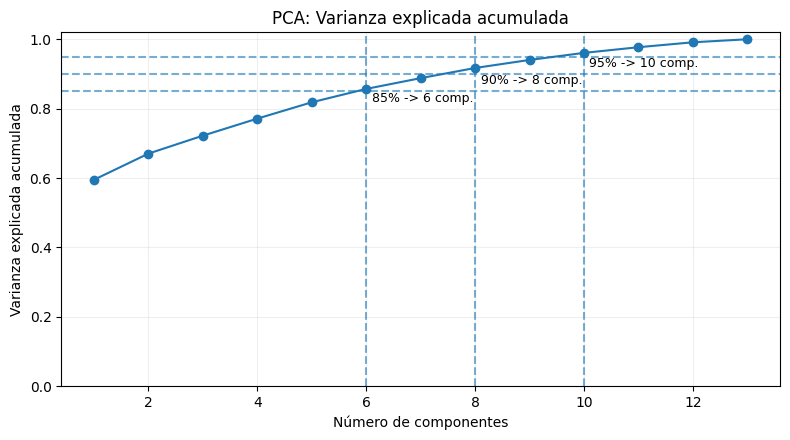

In [14]:
# PCA: varianza explicada y número de componentes
from sklearn.decomposition import PCA

if 'X_scaled' not in globals():
    raise ValueError('No existe X_scaled. Ejecuta las celdas de preprocesamiento y escalado primero.')

pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)

thresholds = [0.85, 0.90, 0.95]
comp_summary = {
    f'componentes_para_{int(t*100)}pct': int(np.argmax(cum_explained >= t) + 1)
    for t in thresholds
}

print('Varianza explicada acumulada (primeros 10 componentes):')
print(np.round(cum_explained[:10], 4))
print('\nComponentes requeridos por umbral:')
display(pd.DataFrame([comp_summary]))

plt.figure(figsize=(8, 4.5))
plt.plot(range(1, len(cum_explained) + 1), cum_explained, marker='o')
for t in thresholds:
    k_t = int(np.argmax(cum_explained >= t) + 1)
    plt.axhline(y=t, linestyle='--', alpha=0.6)
    plt.axvline(x=k_t, linestyle='--', alpha=0.6)
    plt.text(k_t + 0.1, t - 0.03, f'{int(t*100)}% -> {k_t} comp.', fontsize=9)

plt.title('PCA: Varianza explicada acumulada')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.ylim(0, 1.02)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

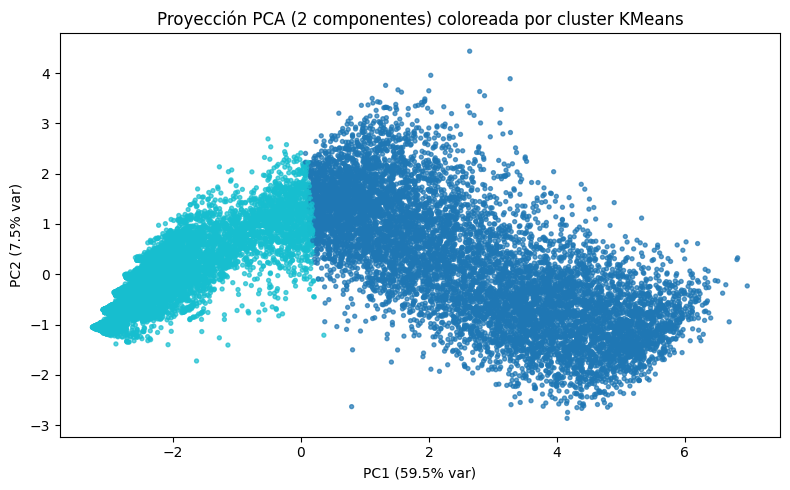

Top variables que más aportan a PC1:


,PC1,PC2
voteCount,0.3122,-0.2517
actorsCount,0.3120,-0.2199
castMenAmount,0.3026,-0.1373
castWomenAmount,0.2870,-0.0758
revenue,0.2869,-0.3910
budget,0.2847,-0.3900
releaseYear,-0.2820,0.0003
runtime,0.2730,0.1819


Top variables que más aportan a PC2:


,PC1,PC2
genresCount,0.2086,0.4307
revenue,0.2869,-0.3910
budget,0.2847,-0.3900
voteAvg,0.2721,0.3746
actorsPopularityMean,0.2509,0.3272
voteCount,0.3122,-0.2517
popularity,0.2728,0.2515
actorsCount,0.3120,-0.2199


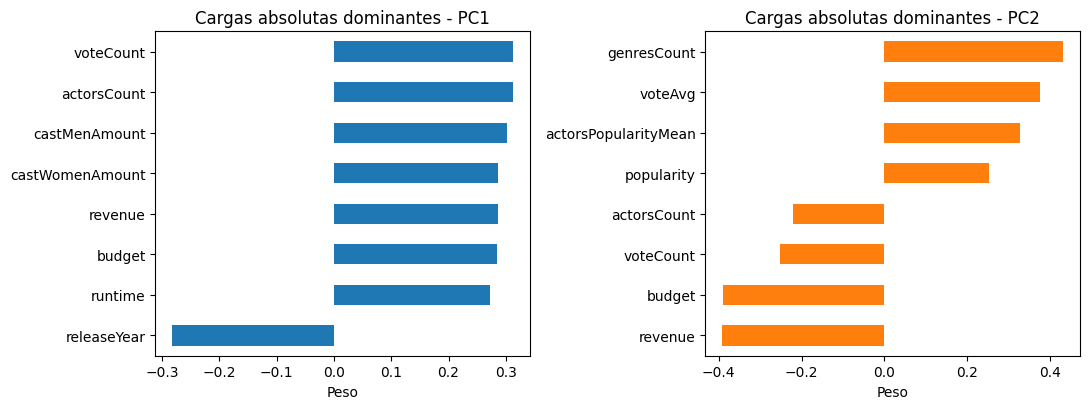

In [15]:
# PCA en 2D para visualización e interpretación de cargas
k_for_vis = 2
pca_2d = PCA(n_components=k_for_vis, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

labels_for_plot = labels_kmeans if 'labels_kmeans' in globals() else None

plt.figure(figsize=(8, 5))
if labels_for_plot is not None:
    plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_for_plot, s=8, cmap='tab10', alpha=0.7)
    plt.title('Proyección PCA (2 componentes) coloreada por cluster KMeans')
else:
    plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], s=8, alpha=0.7)
    plt.title('Proyección PCA (2 componentes)')

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% var)')
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(
    pca_2d.components_.T,
    index=X_scaled.columns,
    columns=['PC1', 'PC2']
)

top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(8).index
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(8).index

print('Top variables que más aportan a PC1:')
display(loadings.loc[top_pc1].sort_values('PC1', key=lambda s: s.abs(), ascending=False).round(4))
print('Top variables que más aportan a PC2:')
display(loadings.loc[top_pc2].sort_values('PC2', key=lambda s: s.abs(), ascending=False).round(4))

fig, axes = plt.subplots(1, 2, figsize=(11, 4.2))
loadings.loc[top_pc1, 'PC1'].sort_values().plot(kind='barh', ax=axes[0], color='tab:blue')
axes[0].set_title('Cargas absolutas dominantes - PC1')
axes[0].set_xlabel('Peso')

loadings.loc[top_pc2, 'PC2'].sort_values().plot(kind='barh', ax=axes[1], color='tab:orange')
axes[1].set_title('Cargas absolutas dominantes - PC2')
axes[1].set_xlabel('Peso')

plt.tight_layout()
plt.show()

## Reglas de Asociación
Se construyen transacciones por película (géneros + idioma original) y se aplican reglas de asociación para identificar combinaciones frecuentes útiles para decisión de contenido.

In [16]:
# Preparación de transacciones (géneros + idioma)
if 'df' not in globals():
    raise ValueError('No existe df. Ejecuta la celda de carga de datos primero.')

# Función para normalizar tokens de texto

def clean_token(x):
    token = str(x).strip()
    return token if token != '' and token.lower() != 'nan' else None

transactions = []
for _, row in df[['genres', 'originalLanguage']].iterrows():
    items = []

    # Géneros
    genres_raw = [] if pd.isna(row['genres']) else str(row['genres']).split('|')
    genres = [clean_token(g) for g in genres_raw]
    genres = [g for g in genres if g is not None]
    items.extend([f'genre={g}' for g in genres])

    # Idioma
    lang = clean_token(row['originalLanguage'])
    if lang is not None:
        items.append(f'lang={lang}')

    # Evitar transacciones vacías
    if len(items) > 0:
        transactions.append(sorted(set(items)))

print(f'Transacciones construidas: {len(transactions)}')
print('Ejemplo de transacción:', transactions[0][:8] if len(transactions) > 0 else [])

Transacciones construidas: 19883
Ejemplo de transacción: ['genre=Crime', 'genre=Drama', 'lang=fa']


In [17]:
# Reglas de asociación con Apriori
import importlib
import subprocess
import sys

if importlib.util.find_spec('mlxtend') is None:
    print('Instalando mlxtend...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'mlxtend', '-q'])

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
basket = pd.DataFrame(te_array, columns=te.columns_)

# Ajusta estos umbrales según densidad de reglas en tu dataset
min_support = 0.03
min_confidence = 0.35
min_lift = 1.10

frequent_itemsets = apriori(basket, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)

if rules.empty:
    print('No se generaron reglas con los umbrales actuales. Prueba bajar soporte/confianza.')
else:
    rules = rules[rules['lift'] >= min_lift].copy()
    rules['antecedents'] = rules['antecedents'].apply(lambda s: ', '.join(sorted(list(s))))
    rules['consequents'] = rules['consequents'].apply(lambda s: ', '.join(sorted(list(s))))
    rules = rules.sort_values(['lift', 'confidence', 'support'], ascending=[False, False, False])

    cols_view = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    print(f'Itemsets frecuentes: {len(frequent_itemsets)}')
    print(f'Reglas encontradas (filtradas): {len(rules)}')
    display(rules[cols_view].head(20).round(4))

Instalando mlxtend...
Itemsets frecuentes: 64
Reglas encontradas (filtradas): 47


,antecedents,consequents,support,confidence,lift
37,genre=Family,"genre=Animation, lang=en",0.0364,0.4153,7.4454
33,"genre=Animation, lang=en",genre=Family,0.0364,0.6519,7.4454
35,"genre=Family, lang=en",genre=Animation,0.0364,0.5379,5.4020
36,genre=Animation,"genre=Family, lang=en",0.0364,0.3652,5.4020
6,genre=Animation,genre=Family,0.0440,0.4419,5.0469
7,genre=Family,genre=Animation,0.0440,0.5026,5.0469
3,genre=Family,genre=Adventure,0.0349,0.3980,3.9473
4,genre=Fantasy,genre=Adventure,0.0324,0.3924,3.8917
30,genre=Adventure,"genre=Action, lang=en",0.0363,0.3596,3.3333
45,"genre=Crime, lang=en",genre=Thriller,0.0326,0.5595,3.2883


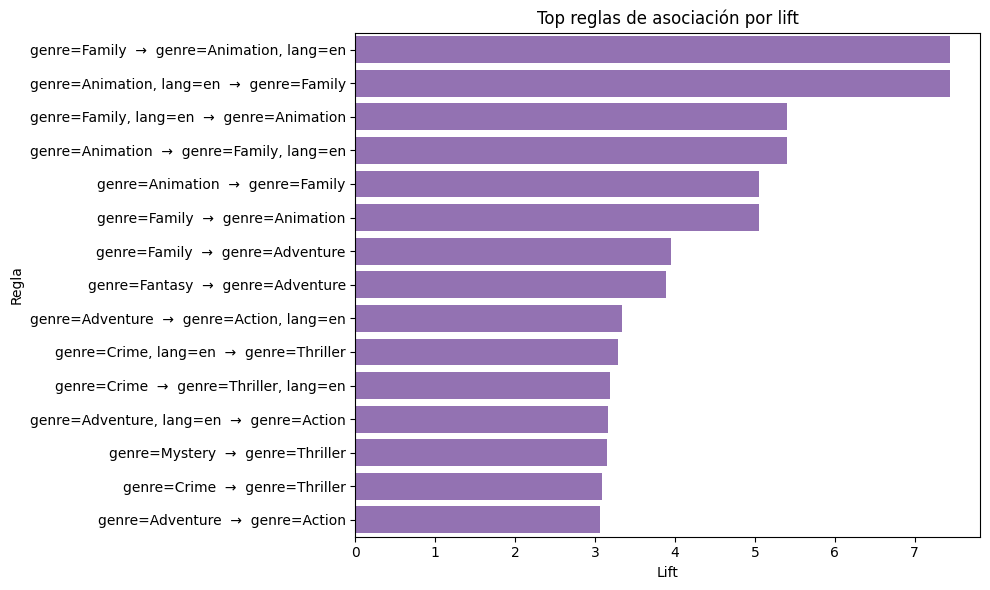

In [18]:
# Visualización rápida de reglas top (lift)
if 'rules' in globals() and not rules.empty:
    top_rules_plot = rules.head(15).copy()
    top_rules_plot['rule'] = top_rules_plot['antecedents'] + '  →  ' + top_rules_plot['consequents']

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_rules_plot, y='rule', x='lift', color='tab:purple')
    plt.title('Top reglas de asociación por lift')
    plt.xlabel('Lift')
    plt.ylabel('Regla')
    plt.tight_layout()
    plt.show()
else:
    print('No hay reglas para visualizar.')